
#Introduction

Object here is to show how we can leverage a large language model with our own data to create an AI applications that can answer questions specific to government policies or subject area. By augmenting prompt with domain specific doument fragments along with a query, model will then respond with answer that based on given context.

To build this appliction, we will crawl a series of document for the given problem statement. We will index these documents into vector database to enable rapid search given a user question. Once done, we will implement an application which combines question with a document to form a porompt and submits that prompt to a model in order to generate response.

At the end, we will package everything into MLFlow model and create an realtime serving endpoint using databricks serving.

# Guardrails For the Enterprise GenAI Applications

## Background

Foundation models are usually trained offline, making the model agnostic to any data that is created after the model was trained. Additionally, foundation models are trained on very general domain corpora, making them less effective for domain-specific tasks. We can build RAG workflow to retrieve data from outside a foundation model and augment your prompts by adding the relevant retrieved data in contxet.  With RAG, the external data used to augment your prompts can come from multiple data sources, such as document repositories, databases or APIs. 

![Pic](/files/tables/arch.png)
<br/>



# Install Required Libraries

In [0]:
%pip install faiss-cpu==1.7.4 openai==0.27.8 langchain==0.0.251 nemoguardrails==0.5.0 tiktoken==0.4.0 pdfminer-six==20221105 watchdog==3.0.0 PyMuPDF==1.23.3 pysqlite-binary

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached langchain-0.0.251-py3-none-any.whl (1.4 MB)
  Using cached nemoguardrails-0.5.0-py3-none-any.whl (13.9 MB)
  Using cached watchdog-3.0.0-py3-none-manylinux2014_x86_64.whl (82 kB)
  Using cached PyMuPDF-1.23.3-cp310-none-manylinux2014_x86_64.whl (4.3 MB)
  Using cached pysqlite_binary-0.5.1.3380300-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.0 MB)
  Using cached langsmith-0.0.37-py3-none-any.whl (38 kB)
  Using cached fastapi-0.96.0-py3-none-any.whl (57 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached simpleeval-0.9.13-py2.py3-none-any.whl (15 kB)
  Using cached setuptools-65.5.1-py3-none-any.whl (1.2 MB)
  Using cached annoy-1.17.3-cp310-cp310-linux_x86_64.whl
  Using cached uvicorn-0.22.0-py3-none-any.whl (58 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Using cached nest_asyncio-1.5.6-py3-none-any.whl 

In [0]:
dbutils.library.restartPython()

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Imports

In [0]:
%run "./utils/config"

In [0]:
%run "./utils/functions"

In [0]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import NLTKTextSplitter
from langchain.vectorstores.faiss import FAISS
import matplotlib.pyplot as plt
import tiktoken

#Crawling the data

In [0]:
%sh
directory="/tmp/conversation_qa_bot_with_guardrails/policies"

if [ ! -d "$directory" ]; then
  mkdir -p "$directory"
  echo "Directory created."
else
  echo "Directory already exists."
fi

curl https://www.smartnation.gov.sg/files/publications/government-personal-data-protection-policies-jul21.pdf -o /tmp/conversation_qa_bot_with_guardrails/policies/government-personal-data-protection-policies-jul21.pdf

curl https://www.smartnation.gov.sg/files/publications/government-data-security-policies.pdf -o /tmp/conversation_qa_bot_with_guardrails/policies/government-data-security-policies.pdf

curl https://www.smartnation.gov.sg/files/publications/key-policies-third-party-framework.pdf -o /tmp/conversation_qa_bot_with_guardrails/policies/key-policies-third-party-framework.pdf

Directory created.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2801k  100 2801k    0     0  1140k      0  0:00:02  0:00:02 --:--:-- 1140k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  591k  100  591k    0     0   307k      0  0:00:01  0:00:01 --:--:--  307k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1155k  100 1155k    0     0   504k      0  0:00:02  0:00:02 --:--:--  504k


# Load the raw data


The crawled is a collection of policies that the Government has put in place strong personal data protection laws and policies to safeguard sensitive and personal data.

In [0]:
data = read_pdf_to_string(config['data_dir_path'])
data

['\u2029\nGovernment Data Security Policies  |   �1\nGOVERNMENT \nDATA SECURITY \nPOLICIES\nThis document contains general information for the \npublic only. It is not intended to be relied upon as a \ncomprehensive or deﬁnitive guide on each agency’s \npolicies and practices. The data security measures \nimplemented by each agency will differ depending on \nvarious factors such as the sensitivity of the data and \nthe agency’s assessment of data security risks. The \nGovernment may update the policies set out in this \ndocument without publishing such updates to the \npublic.    \nThe Government takes its responsibility as a \ncustodian of data very seriously.\nSince 2001, the Government’s data security policies have been set out in the Government \nInstruction Manual (IM) on Infocomm Technology and Smart Systems (ICT&SS) Management. In \n2019, the Public Sector Data Security Review Committee recommended additional technical and \nprocess measures to protect data and prevent data comp

In [0]:
len(data)

3

# Chunk Analysis

Every record contains *a lot* of text. Our first task is therefore to identify a good preprocessing methodology for chunking these articles into more "concise" chunks to later be embedding and stored in our FAISS vector index.
For this we use LangChain's `RecursiveCharacterTextSplitter` to split our text into chunks of a specified max length.

In [0]:
tiktoken.encoding_for_model(config['openai_chat_model'])

<Encoding 'cl100k_base'>

Note that for the tokenizer we defined the encoder as `"cl100k_base"`. This is a specific tiktoken encoder which is used by `gpt-3.5-turbo`. Other encoders exist. At the time of writing the OpenAI specific tokenizers (using `tiktoken`) are summarized as:

| Encoder | Models |
| --- | --- |
| `cl100k_base` | `gpt-4`, `gpt-3.5-turbo`, `text-embedding-ada-002` |
| `p50k_base` | `text-davinci-003`, `code-davinci-002`, `code-cushman-002` |
| `r50k_base` | `text-davinci-001`, `davinci`, `text-similarity-davinci-001` |
| `gpt2` | `gpt2` |

You can find these details in the [Tiktoken `model.py` script](https://github.com/openai/tiktoken/blob/main/tiktoken/model.py), or using `tiktoken.encoding_for_model`:

Looks good, we need to also consider the length of each page with respect to the number of tokens that will reasonably fit within the window of the latest LLMs. We will use `gpt-3.5-turbo` as an example.

To count the number of tokens that `gpt-3.5-turbo` will use for some text we need to initialize the `tiktoken` tokenizer.

In [0]:
tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

Using the `tiktoken_len` function, let's count and visualize the number of tokens across our webpages.

In [0]:
token_counts = [tiktoken_len(doc) for doc in data]
token_counts

[6938, 11389, 941]

In [0]:
print(f"\nToken Counts-\n")
for token_count in token_counts:
    print(f"\t{token_count}\n")


Token Counts-

	6938

	11389

	941



Using the `tiktoken_len` function, let's count and visualize the number of tokens across our pdfs.

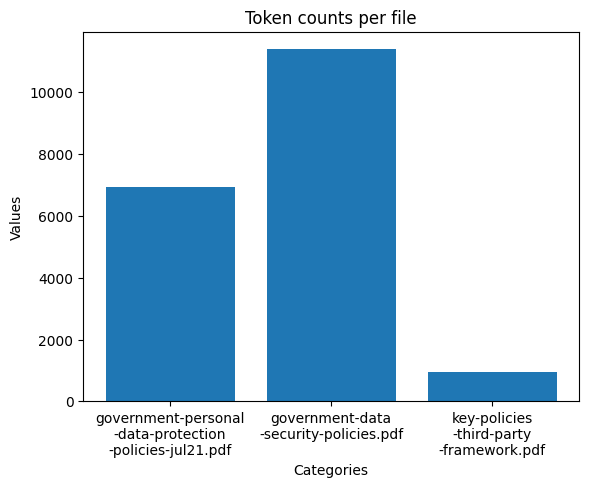

In [0]:
data_files = ['government-personal\n-data-protection\n-policies-jul21.pdf', 'government-data\n-security-policies.pdf', 'key-policies\n-third-party\n-framework.pdf']

# Create a bar plot
plt.bar(data_files, token_counts)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Token counts per file')

# Show the plot
plt.show()

Most of the data has more tokens than the limit. But, how do we decide what this number should be?

# Prepare data for indexing

Fields that are important for us are
- context : knowledge base for a given question
- title : knowledge base source

### Chunking the Text

At the time of writing, `gpt-3.5-turbo` supports a context window of 4096 tokens — that means that input tokens + generated ( / completion) output tokens, cannot total more than 4096 without hitting an error.

So we 100% need to keep below this. If we assume a very safe margin of ~2000 tokens for the input prompt into `gpt-3.5-turbo`, leaving ~2000 tokens for conversation history and completion.

With this ~2000 token limit we may want to include *five* snippets of relevant information, meaning each snippet can be no more than **400** token long.

To create these snippets we use the `RecursiveCharacterTextSplitter` from LangChain. To measure the length of snippets we also need a *length function*. This is a function that consumes text, counts the number of tokens within the text (after tokenization using the `gpt-3.5-turbo` tokenizer), and returns that number. We define it like so:

Different Chunking Strategies : https://www.pinecone.io/learn/chunking-strategies/

In [0]:
chunk_size = 600
chunk_overlap = 100

In [0]:
text_splitter = NLTKTextSplitter(separator=".", chunk_size=chunk_size, chunk_overlap=chunk_overlap)
# split text into chunks
text_content = []
for doc in data:
    text_content.extend(text_splitter.split_text(doc))

Created a chunk of size 2465, which is longer than the specified 600
Created a chunk of size 1109, which is longer than the specified 600
Created a chunk of size 2231, which is longer than the specified 600
Created a chunk of size 602, which is longer than the specified 600
Created a chunk of size 747, which is longer than the specified 600
Created a chunk of size 958, which is longer than the specified 600
Created a chunk of size 720, which is longer than the specified 600
Created a chunk of size 903, which is longer than the specified 600
Created a chunk of size 910, which is longer than the specified 600
Created a chunk of size 764, which is longer than the specified 600
Created a chunk of size 645, which is longer than the specified 600
Created a chunk of size 1033, which is longer than the specified 600
Created a chunk of size 740, which is longer than the specified 600
Created a chunk of size 972, which is longer than the specified 600
Created a chunk of size 880, which is longer

In [0]:
for text in text_content:
    if "10 or less years" in text:
        print("\n\n\n\n\n\n\n\n" + text)









This document sets out the key policies in the IM on ICT&SS Management that govern how 
personal data is managed and protected by agencies..These policies apply to all personal data (in electronic (structured and unstructured) and 
non-electronic forms) possessed, controlled, or processed by an agency, except: 
(a)
Personal data of a deceased individual (However, provisions relating to the disclosure 
of personal data and protection of personal data shall apply in respect of the 
personal data of an individual who has been dead for 10 or less years..); and 
(b)
Business contact information.


# Create vector store/index

Now we will initialize the vectore store/index into which we will load the data. Vector databases are specialized database that store text data as embeddings and enable fast searches based on the content similarity. We will be using Chroma DB which is the open-source embedding database that makes it easy to build LLM apps by making knowledge, facts, and skills pluggable for LLMs.

We need to set up the embedding model that it will use to convert both the documents and any searchable text to an embedding or vector.

In [0]:
# identify embedding model that will generate embedding vectors
embeddings = OpenAIEmbeddings(model=config['openai_embedding_model'])

vector_store = FAISS.from_texts(
  embedding=embeddings, 
  texts=text_content
  )

In [0]:
vector_store.save_local(folder_path=config['vector_store_path'])